# PDBe API Training

## PDBe Ligand Interactions for a given protein

This tutorial will guide you through searching PDBe for ligand interactions programmatically.


## Setup

First we will import the code which is required to search the API and plot the results.

Run the cell below by pressing the play button or `Ctrl+Enter`.

In [68]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'..')

---
---

## Obtaining data

Now we are ready to find all the ligands and its interaction details bound to a given 
protein.

We will get ligands for the Human Acetylcholinesterase, which has the UniProt accession 
P22303. Because we will be retrieving ligand data multiple times throughout this 
notebook, 

In [69]:
def get_url(url):
    """
    Makes a request to a URL. Returns a JSON of the results
    """
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    
    else:
        print("[No data retrieved - %s] %s" % (response.status_code, response.text))

    return {}

In [70]:
BASE_URL = "https://www.ebi.ac.uk/pdbe/"  # the beginning of the URL for PDBe's API.
PDBEKB_UNIPROT_URL = BASE_URL + "graph-api/uniprot/"

def get_ligand_site_data(uniprot_accession):
    """
    Retrieve ligand site data for a given UniProt accession
    """

    url = PDBEKB_UNIPROT_URL + "ligand_sites/" + uniprot_accession
    print(url)

    data = get_url(url=url)
    data_to_ret = []

    for data_uniprot_accession in data:
        accession_data = data.get(data_uniprot_accession)

        for row in accession_data['data']:
            print("Row", row)
            ligand_accession = row['accession']
            name = row['name']

            # Get the number of atoms in the ligand, return {} if not found
            num_atoms = row.get('additionalData', {})
            num_atoms = num_atoms['numAtoms']

            for residue in row["residues"]:
                print("Residue", residue)
                residue['ligand_accession'] = ligand_accession
                residue['ligand_name'] = name
                residue['ligand_num_atoms'] = num_atoms
                residue['uniprot_accession'] = uniprot_accession

                # Calculate the interaction ratio, empty list if no interaction data
                residue['interaction_ratio'] = len(
                    residue.get('interactingPDBEntries', [])
                ) / len(
                    residue.get('allPDBEntries', [])
                )

                data_to_ret.append(residue)

    return data_to_ret

The next block may take a few seconds...

In [71]:
uniprot_accession = 'P22303'
ligand_data = get_ligand_site_data(uniprot_accession=uniprot_accession)

https://www.ebi.ac.uk/pdbe/graph-api/uniprot/ligand_sites/P22303
Row {'name': 'N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethylene)hydrazineyl)ethan-1-aminium', 'accession': 'LWL', 'residues': [{'startIndex': 117, 'endIndex': 117, 'startCode': 'TRP', 'endCode': 'TRP', 'indexType': 'UNIPROT', 'interactingPDBEntries': [{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}], 'allPDBEntries': ['8aen']}, {'startIndex': 152, 'endIndex': 152, 'startCode': 'GLY', 'endCode': 'GLY', 'indexType': 'UNIPROT', 'interactingPDBEntries': [{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}], 'allPDBEntries': ['8aen']}, {'startIndex': 153, 'endIndex': 153, 'startCode': 'GLY', 'endCode': 'GLY', 'indexType': 'UNIPROT', 'interactingPDBEntries': [{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}], 'allPDBEntries': ['8aen']}, {'startIndex': 155, 'endIndex': 155, 'startCode': 'TYR', 'endCode': 'TYR', 'indexType': 'UNIPROT', 'interactingPDBEntries': [{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}], 'allPDBEntries':

The above code gets a list of all ligands which interact with the UniProt. The function "get_ligand_site_data" also calculates interaction ratio for each residue within their respective ligand binding site.

The interaction ratio for each residue within a ligand binding site is calculated by dividing the total number of PDB entries where the given residue interacts with the ligand by the total number of PDB entries that bind to that ligand. The interaction ratio represents the proportion of PDB entries that show an interaction between the residue and the specific ligand.

This is a lot of information so it will need reformatting to become useful

In [102]:
# Print data - Warning there is a lot of data here!
print(ligand_data)

[{'startIndex': 117, 'endIndex': 117, 'startCode': 'TRP', 'endCode': 'TRP', 'indexType': 'UNIPROT', 'interactingPDBEntries': [{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}], 'allPDBEntries': ['8aen'], 'ligand_accession': 'LWL', 'ligand_name': 'N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethylene)hydrazineyl)ethan-1-aminium', 'ligand_num_atoms': 16, 'uniprot_accession': 'P22303', 'interaction_ratio': 1.0}, {'startIndex': 152, 'endIndex': 152, 'startCode': 'GLY', 'endCode': 'GLY', 'indexType': 'UNIPROT', 'interactingPDBEntries': [{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}], 'allPDBEntries': ['8aen'], 'ligand_accession': 'LWL', 'ligand_name': 'N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethylene)hydrazineyl)ethan-1-aminium', 'ligand_num_atoms': 16, 'uniprot_accession': 'P22303', 'interaction_ratio': 1.0}, {'startIndex': 153, 'endIndex': 153, 'startCode': 'GLY', 'endCode': 'GLY', 'indexType': 'UNIPROT', 'interactingPDBEntries': [{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}], 'all

---
---

## Reformatting the data

In [73]:
# TODO: Explain this function. 

def explode_dataset(result, column_to_explode=None):
    """
    Expand a dataset by exploding a column that contains a list of values
    """
    
    df = pd.DataFrame(result)
    if column_to_explode:
        df = df.explode(column=column_to_explode).reset_index(drop=True)

    else:
        for column in df.select_dtypes(include='object'):
            df = df.explode(column=column).reset_index(drop=True)

    return df

In [74]:
df2 = explode_dataset(result=ligand_data, column_to_explode='interactingPDBEntries')
df2

,startIndex,endIndex,startCode,endCode,indexType,interactingPDBEntries,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio
0,117,117,TRP,TRP,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.000000
1,152,152,GLY,GLY,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.000000
2,153,153,GLY,GLY,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.000000
3,155,155,TYR,TYR,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.000000
4,233,233,GLU,GLU,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2202,562,562,PHE,PHE,UNIPROT,"{'pdbId': '7p1n', 'entityId': 2, 'chainIds': 'A'}","[6o5r, 2x8b, 7p1n, 8aen, 7p1p, 4bdt, 8aev, 6f2...",CL,CHLORIDE ION,1,P22303,0.333333
2203,562,562,PHE,PHE,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'B'}","[6o5r, 2x8b, 7p1n, 8aen, 7p1p, 4bdt, 8aev, 6f2...",CL,CHLORIDE ION,1,P22303,0.333333
2204,562,562,PHE,PHE,UNIPROT,"{'pdbId': '7p1p', 'entityId': 2, 'chainIds': 'B'}","[6o5r, 2x8b, 7p1n, 8aen, 7p1p, 4bdt, 8aev, 6f2...",CL,CHLORIDE ION,1,P22303,0.333333
2205,565,565,ARG,ARG,UNIPROT,"{'pdbId': '6f25', 'entityId': 1, 'chainIds': 'B'}","[6o5r, 2x8b, 7p1n, 8aen, 7p1p, 4bdt, 8aev, 6f2...",CL,CHLORIDE ION,1,P22303,0.111111


Some post processing is required to separating interactingPDBEntries into separate columns

In [103]:
df2.head()

,startIndex,endIndex,startCode,endCode,indexType,interactingPDBEntries,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio
0,117,117,TRP,TRP,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0
1,152,152,GLY,GLY,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0
2,153,153,GLY,GLY,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0
3,155,155,TYR,TYR,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0
4,233,233,GLU,GLU,UNIPROT,"{'pdbId': '8aen', 'entityId': 1, 'chainIds': 'A'}",[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0


In [104]:
data = pd.json_normalize(df2['interactingPDBEntries'])
df3 = df2.join(data)
df3 = df3.drop(columns='interactingPDBEntries')


startIndex and endIndex are the UniProt residue number, so we'll make a new column called residue_number
and copy the startIndex there.
We are also going to "count" the number of results - so we'll make a dummy count column to store it in

In [77]:
df3['residue_number'] = df3['startIndex']
df3['count'] = df3['pdbId']

---
---

## Exploratory analysis

Now that the data has been reformatted we are ready to perform some exploratory analysis.

In [78]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,117,117,TRP,TRP,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,117,8aen
1,152,152,GLY,GLY,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,152,8aen
2,153,153,GLY,GLY,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,153,8aen
3,155,155,TYR,TYR,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,155,8aen
4,233,233,GLU,GLU,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,233,8aen


A higher interaction ratio indicates that the residue is more likely to consistently interact with the ligand across multiple protein structures. It suggests that the residue plays a crucial role in the binding of the ligand within the binding site. On the other hand, a lower interaction ratio suggests that the residue's interaction with the ligand may be less consistent or may occur in a more context-dependent manner.

By calculating the interaction ratio for each residue within a ligand binding site, you can gain insights into the residues that are consistently involved in the binding of a specific ligand. This information can be valuable in understanding the key interactions between the ligand and the protein and potentially guide further studies or drug design efforts targeting that binding site.

Ligands which tend to interact with well-defined residues consistently across all PDB entries have interaction_ratio of 1.0. So lets get them....

In [105]:
# Select the rows where the interaction ratio is exactly 1.0
interaction_ration_1 = df3[df3['interaction_ratio'] == 1.0]
ret = interaction_ration_1['ligand_accession'].unique()
print(ret)

['LWL' 'THA' 'AA' '4IX' '4J1' '3VI' 'HLO' 'HI6' 'LND' 'CVZ' 'H0R' 'E20'
 'H1R' 'H0L' '1YK' '1YL' 'LWU' 'EBW' 'QRH' 'FP1' 'HUP' 'MES' 'PQY' 'GAL'
 'FUL' 'SIA' 'NAG' 'PQV' 'WW2' 'UCY' 'GNT' 'HUW' 'BR' '1PE' 'PE8' 'ZN'
 '7PE' 'EFS' 'ELT' 'PEG' 'UCJ' 'NWA' 'GD8' 'DEP' 'L2Y' 'EDO' 'L1M' 'L0S'
 'VX' 'SO4']


Lets see if we can filter ligands by which ligands interact with the residues which have the most interactions.

First lets see how many interactions we have per residue.

In [80]:
# Group by residue number and count the number of rows
df4 = df3.groupby('residue_number')['count']
df4 = df4.count().reset_index()

<Axes: xlabel='residue_number', ylabel='count'>

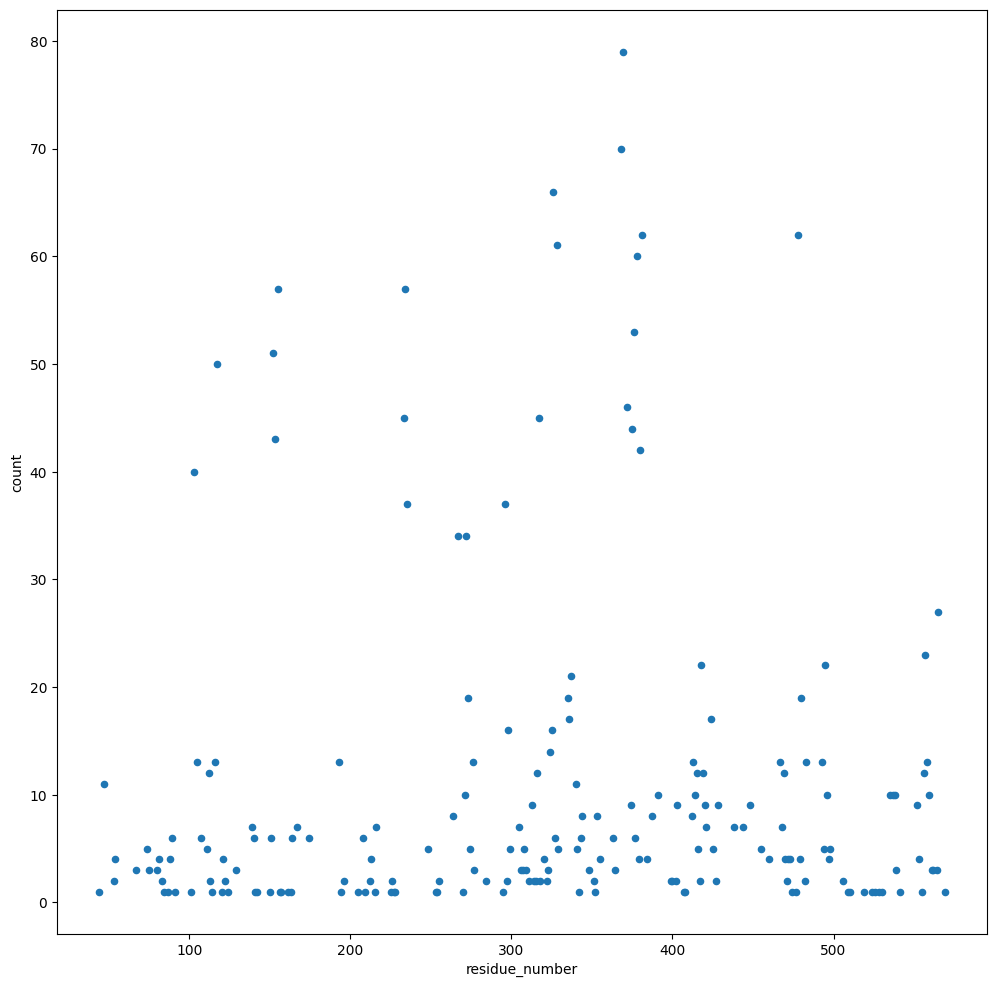

In [81]:
# Plotting data directly from a Pandas DataFrame
df4.plot.scatter(x='residue_number', y='count')

---
---

## Obtaining summary statistics

We can also obtain summary statistics for the interactions. 

For example, the mean number of interactions and the standard deviation

In [82]:
mean = df4.mean()
std = df4.std()

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: residue_number    321.925743
count              10.925743
dtype: float64
Standard deviation: residue_number    146.458285
count              15.796890
dtype: float64


To make the number easier to access, we can extract them and save them to new variables:

In [83]:
mean_value = float(mean.values[1])
std_value = float(std.values[1])

print(f"Mean: {mean_value}")
print(f"Standard deviation: {std_value}")

Mean: 10.925742574257425
Standard deviation: 15.796889633173235


---
---

## Finding the residues that form the most interactions

Then we can plot residues which have more interactions than the mean in red
and those which are equal to or below in blue.

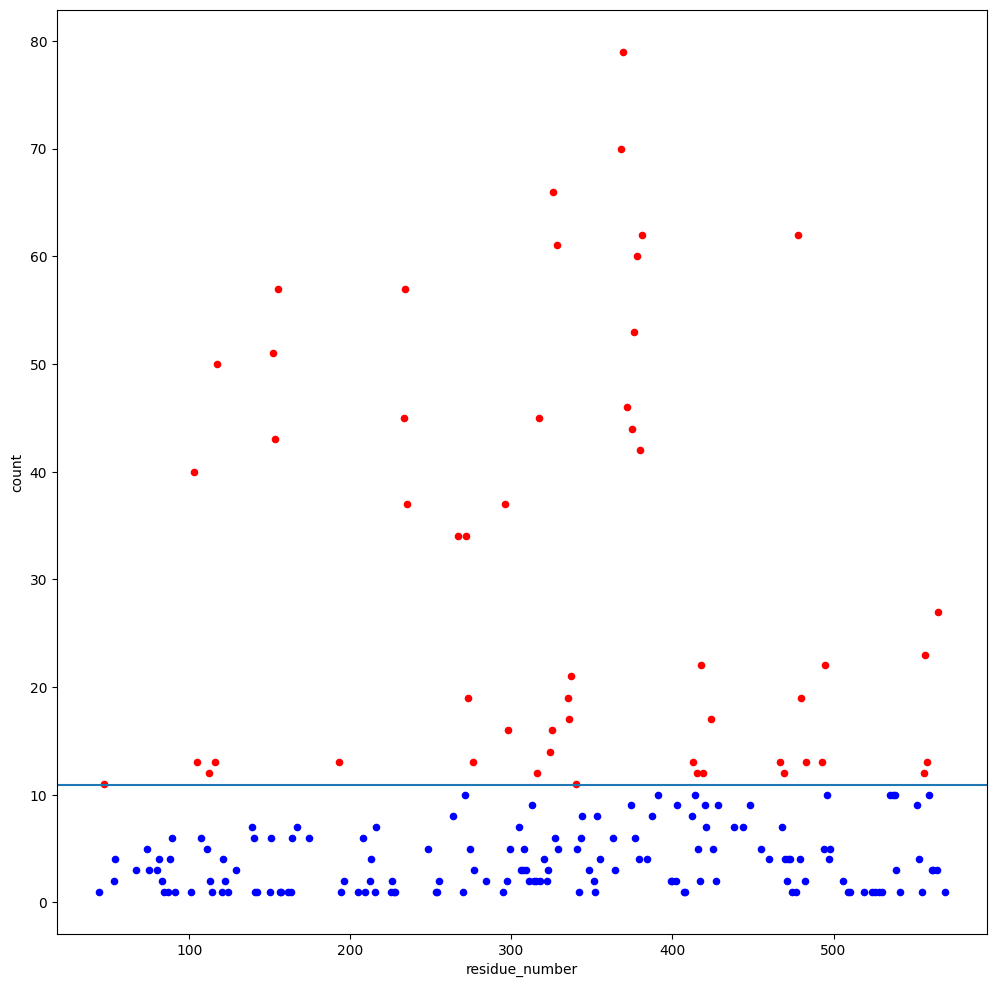

In [106]:
fig, ax = plt.subplots() # this makes one plot with an axis "ax" which we can add several plots to

lt_data = df4[df4['count'] <= mean_value]
lt_data.plot.scatter(
    x='residue_number', 
    y='count', 
    color='blue', 
    ax=ax
)

gt_data = df4[df4['count'] > mean_value]
gt_data.plot.scatter(
    x='residue_number', 
    y='count', 
    color='red', 
    ax=ax
)

ax.axhline(mean_value)

plt.show()
plt.close()

A higher threshold (two standard deviations) would be more useful to select only the most common ligand-binding residues

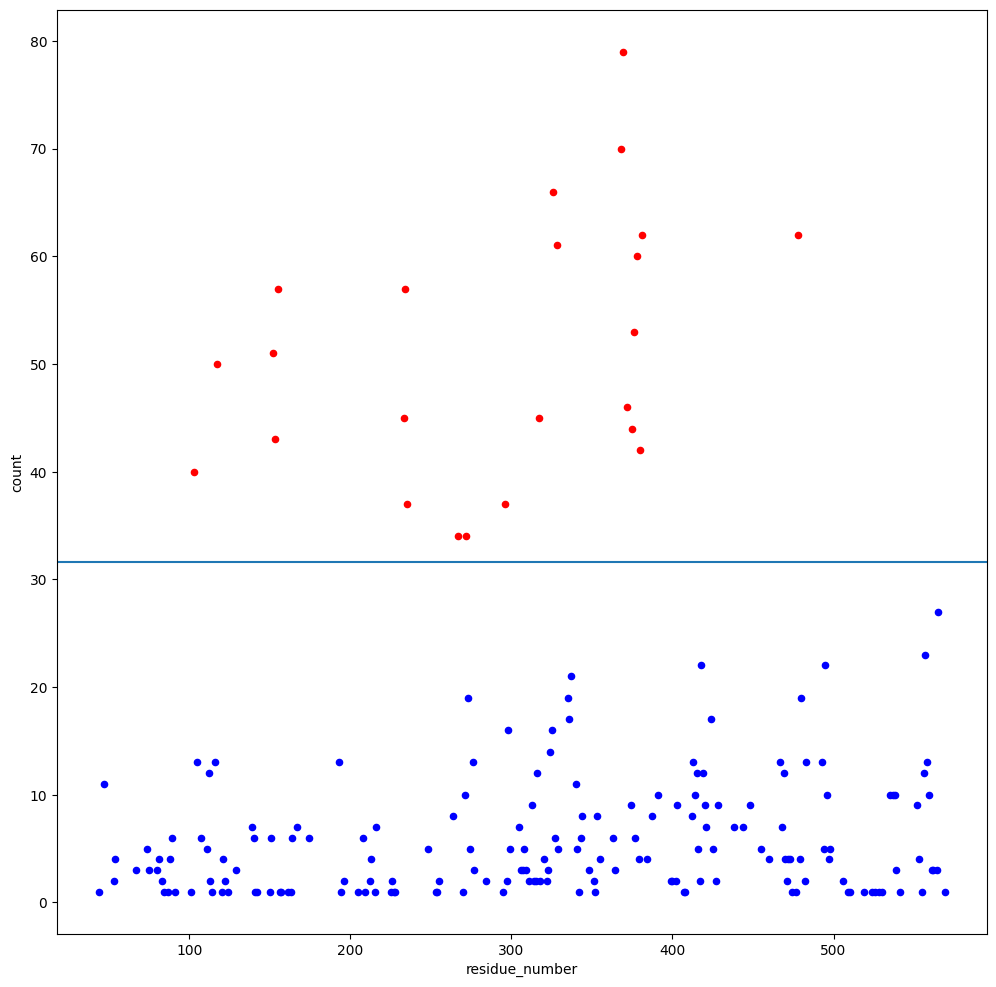

In [108]:
# Makes one plot with an axis "ax" which we can add several plots to
fig, ax = plt.subplots() 

two_std_value = std_value * 2

lt_data = df4[df4['count'] <= two_std_value]
lt_data.plot.scatter(
    x='residue_number', 
    y='count', 
    color='blue', 
    ax=ax
)

gt_data = df4[df4['count'] > two_std_value]
gt_data.plot.scatter(
    x='residue_number', 
    y='count', 
    color='red', 
    ax=ax
)

ax.axhline(two_std_value)

plt.show()
plt.close()

A list of the residues that form the most interactions (over 2 std) can be obtained:

In [110]:
# Select the rows where the count is greater than two standard deviations
all_data_over_two_std = df4[df4['count'] > two_std_value]

# Sort the data by count in descending order
all_data_over_two_std = all_data_over_two_std.sort_values(
    by='count', 
    ascending=False
)

all_data_over_two_std.head()


,residue_number,count
119,369,79
118,368,70
99,326,66
166,478,62
128,381,62


---
---

## Finding the ligands that interact with these residues

we only want the residue numbers for the next step

In [87]:
residue_numbers_over_two_std = all_data_over_two_std['residue_number']
print(residue_numbers_over_two_std)

119    369
118    368
99     326
166    478
128    381
101    328
125    378
38     155
61     234
123    376
36     152
24     117
120    372
92     317
60     233
122    375
37     153
127    380
16     103
78     296
62     235
71     272
68     267
Name: residue_number, dtype: int64


What ligands interact with these residues?

Now we want to get all ligand_accessions which interact with a residue in "residue_numbers_over_two_std"

In [88]:
df5  = df3[df3['residue_number'].isin(residue_numbers_over_two_std)]['ligand_accession']
print(df5)

0       LWL
1       LWL
2       LWL
3       LWL
4       LWL
       ... 
2105     CL
2106     CL
2107     CL
2108     CL
2109     CL
Name: ligand_accession, Length: 1175, dtype: object


The same ligand appears several times so we an "unique" the list to get our list of ligands
which have a number of interactions over the mean interaction count.

In [89]:
interesting_ligands = list(df5.unique())
print(interesting_ligands)

['LWL', 'THA', 'AA', '4IX', '4J1', '3VI', 'HLO', 'HI6', 'LND', 'CVZ', 'H0R', 'E20', 'H1R', 'H0L', '1YK', '1YL', 'LWU', 'EBW', 'QRH', 'FP1', 'HUP', 'MES', 'PQY', 'FUL', 'FUC', 'NAG', 'PQV', 'WW2', 'UCY', 'GNT', 'HUW', 'GOL', '1PE', 'PE8', 'ZN', '7PE', 'EFS', 'ELT', 'DMS', 'UCJ', 'NWA', 'GD8', 'DEP', 'L2Y', 'L1M', 'L0S', 'NO3', 'VX', 'SO4', 'CL']


PDBe-KB annotates ligands as drug-like, co-factor-like or reactant-like. This mapping is based on mapping to DrugBank, similarity with co-factor templates or ChEBI/Rhea databases. Let's see if any of these interesting_ligands we found has any functional role.

In [90]:
LIGAND_ROLE_URL = PDBEKB_UNIPROT_URL + "ligands/"

def get_ligand_role_data(uniprot_accession):
    """
    Retrieve ligand role data for a given UniProt accession
    """

    url = LIGAND_ROLE_URL + uniprot_accession
    my_data = get_url(url=url)
    data = my_data[uniprot_accession]
    data_to_ret = []

    for ligand_row in data :
        for ligand in ligand_row :
            dict1 = ligand_row[ligand]

            dict1['pdbs'] = ",".join(dict1['pdbs'])
            dict1['acts_as'] = ",".join(
                # Example of a technique called list comprehension
                [item.strip() for item in dict1['acts_as']]
            )

            dict2 = {"ligand_code":ligand}
            # Example of a technique called dictionary comprehension
            dict3 = {k:v for d in (dict1,dict2) for k,v in d.items()}
            
            data_to_ret.append(dict3)

    return data_to_ret

In [91]:
# get ligand annotations from PDBe-KB
data = get_ligand_role_data(uniprot_accession)
print(data[0])

{'name': 'HUPRINE W', 'pdbs': '4bdt', 'acts_as': '', 'scaffold_id': 'C1=C[C@@H]2Cc3nc4ccccc4cc3[C@H](C1)C2', 'fragments': ['c1ccc2ncccc2c1', 'c1ccncc1', 'c1ccccc1'], 'directly_interacts': True, 'ligand_code': 'HUW'}


In [111]:
# convert the data in pandas dataframe
df = pd.DataFrame(data)
df.head()

,pdbId,entityId,chainIds
0,8aen,1,A
1,8aen,1,A
2,8aen,1,A
3,8aen,1,A
4,8aen,1,A


In [93]:
# Find all the ligand which have any functional role
df[df['acts_as'] != '']

,name,pdbs,acts_as,scaffold_id,fragments,directly_interacts,ligand_code
1,(-)-GALANTHAMINE,4ey6,drug-like,C1=C[C@@]23CCNCc4cccc(c42)O[C@H]3CC1,"[c1ccccc1, c1ccc2c(c1)CCO2]",True,GNT
32,TACRINE,7xn1,drug-like,c1ccc2nc3c(cc2c1)CCCC3,"[c1ccc2ncccc2c1, c1ccccc1, c1ccncc1]",True,THA


It's worth seeing which ligands are not in our list

In [94]:
all_ligands = list(df3['ligand_accession'].unique())

# List comprehension to find all ligands which have a functional role
missing_ligands = [x for x in all_ligands if x not in interesting_ligands]
missing_ligands

['GAL', 'SIA', 'BR', 'PEG', 'EDO', 'MG']

Now we can display the interactions only for those ligands we have found

We will start with our Dataframe df3

In [95]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,117,117,TRP,TRP,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,117,8aen
1,152,152,GLY,GLY,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,152,8aen
2,153,153,GLY,GLY,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,153,8aen
3,155,155,TYR,TYR,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,155,8aen
4,233,233,GLU,GLU,UNIPROT,[8aen],LWL,"N,N,N-trimethyl-2-oxo-2-(2-(pyridin-2-ylmethyl...",16,P22303,1.0,8aen,1,A,233,8aen


We will select only ligands which interact the most in a Dataframe df6

In [96]:
df6 = df3.groupby(['residue_number', 'ligand_accession'])

df6 = df6['interaction_ratio'].mean().reset_index()
df6

,residue_number,ligand_accession,interaction_ratio
0,44,CL,0.111111
1,47,CL,0.666667
2,47,SO4,0.500000
3,53,CL,0.111111
4,53,SO4,0.100000
...,...,...,...
772,565,EDO,1.000000
773,565,MG,0.250000
774,565,NO3,0.315789
775,565,SO4,0.700000


Now we can plot the ligand interactions of those ligands which interact with the most interacting residues.

We will put each ligand on a row and scale the interactions by the percentage of PDB entries they are seen in.


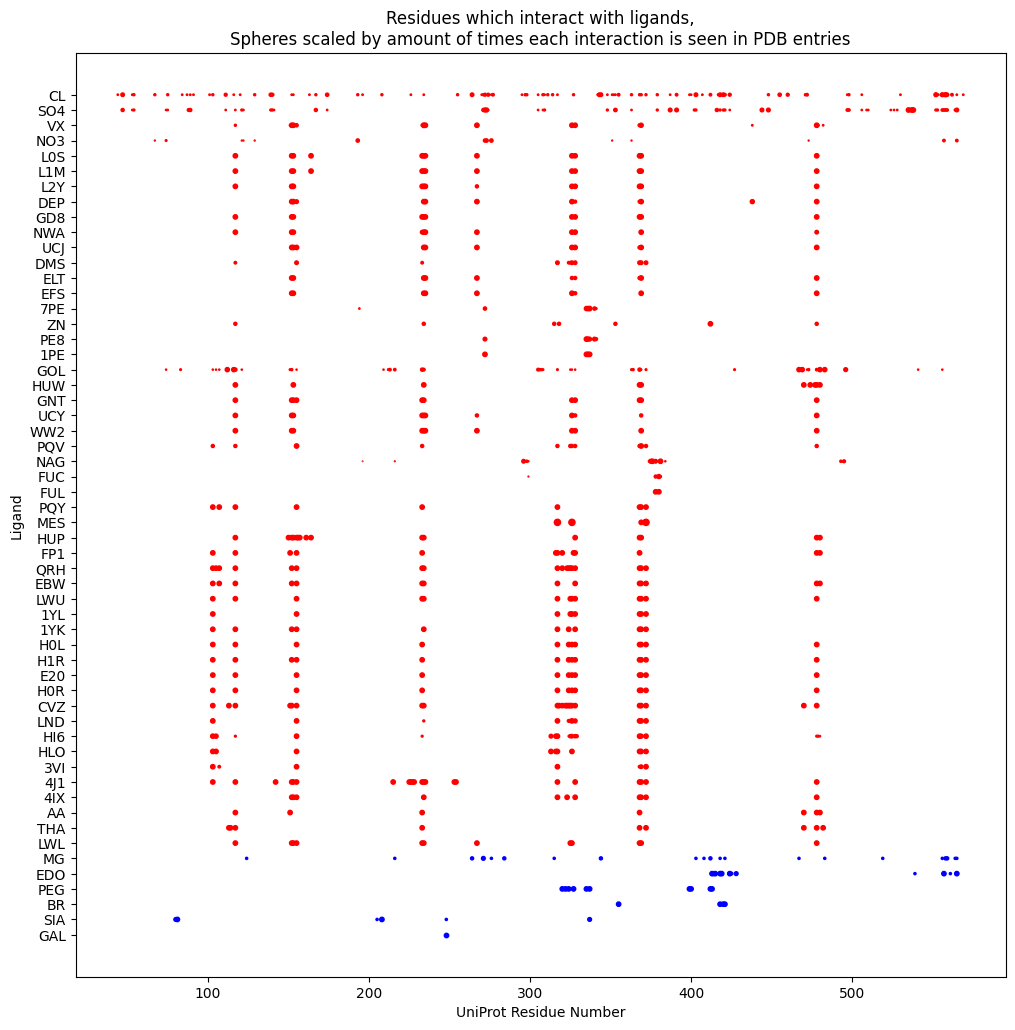

In [97]:
# prepare a figure
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

# plot the less interesting ligands in blue
for ligand in missing_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    data.plot.scatter(
        x='residue_number', 
        y='ligand_accession', 
        ax=ax, 
        s=data['interaction_ratio']*10,
        c='blue'
    )

# plot the interesting ligands in red
for ligand in interesting_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    data.plot.scatter(
        x='residue_number', 
        y='ligand_accession', 
        ax=ax, 
        s=data['interaction_ratio']*10,
        c='red'
    )

plt.ylabel('Ligand')
plt.xlabel('UniProt Residue Number')
plt.title('Residues which interact with ligands,\nSpheres scaled by amount of times each interaction is seen in PDB entries')
plt.show()
plt.close()

---
---

## Comparing the chemical structures of ligands

It would be interesting to see if the similar ligands bind to the same residues. Let's take any ligand from above interesting ligand dataset and find all the other ligands which are similar to it. 

In the example below, we have taken the neurotoxin VX (HET CODE- VX) and acetylcholinesterase inhibitor. We found all the ligands similar to VX using "get_similar_ligand_data" function. This function takes ligand name and similarity cutoff (0-1) as arguments. Here we have used similarity cutoff of 0.7 and found all the ligands which are 70 % or more similar to VX. 

In [98]:
PDBEKB_LIGAND_URL = BASE_URL + "graph-api/compound/"

def get_similar_ligand_data(het_code, similarity_cutoff):
    """
    Retrieve similar ligand data for a given ligand code
    """

    url = PDBEKB_LIGAND_URL + "similarity/" + het_code
    data = get_url(url=url)
    similar_ligands ={}
    
    for row in data[het_code] :

        if 'similar_ligands' in row :
            sl = row['similar_ligands']

            for lig in sl :
                
                if float(lig['similarity_score']) >= similarity_cutoff :
                    similar_ligands[lig['chem_comp_id']] = lig['similarity_score']

    return similar_ligands

In [99]:
ligand_exp = "VX"
similarity_cutoff = 0.7

# Finding similar ligands to ligand_exp 
similar_ligands = get_similar_ligand_data(ligand_exp, similarity_cutoff)
sdf = pd.DataFrame(
    similar_ligands.items(), 
    columns = ['similar_ligand','similarity_score']
)

# Find common ligands from similar_ligands and interesting_ligands
common_ligands = [item for item in similar_ligands if item in interesting_ligands]
print(f"Common ligands include - {common_ligands}")

Common ligands include - ['EFS']


Now, you can compare if VX and common_ligands bind to same residues or not and check if similar ligands tend to bind to similar sites.

In [100]:
# Get the binding site for your ligand of interest
binding_site_1 = sorted(
    df3[df3['ligand_accession'] == 'VX']['residue_number'].unique()
)
print(f"Binding site for VX: {binding_site_1}")

# Get binding site for common ligands 
common_binding_residues = []
for ligand in common_ligands :
    binding_site_2 = sorted(
        df3[df3['ligand_accession'] == ligand]['residue_number'].unique()
    )
    print(f"Binding site for {ligand}: {binding_site_2}")
    common_binding_residues += [item for item in binding_site_2 if item in binding_site_1]
    
print(f"Common binding site residues {common_binding_residues}")

Binding site for VX: [117, 151, 152, 153, 155, 233, 234, 235, 267, 326, 328, 368, 369, 438, 478, 479, 482]
Binding site for EFS: [152, 153, 234, 235, 267, 326, 328, 369, 478]
Common binding site residues [152, 153, 234, 235, 267, 326, 328, 369, 478]
